Grey world

In [1]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

In [2]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)

top_path = './data/box_img/Top/'
bot_path = './data/box_img/Bot/'

top_path_list = [f'./data/box_img/Top/Top_{i}.jpg' for i in range(0, 127)]
bot_path_list = [f'./data/box_img/Bot/Bot_{i}.jpg' for i in range(0, 127)]

In [16]:
def grey_world_color_correction(image):
    # Convert the image to floating-point format for accurate calculations
    image_float = image.astype(np.float32)
    
    # Calculate the average color value for each channel (R, G, B)
    avg_color_per_channel = np.mean(image_float, axis=(0, 1))
    
    # Calculate the overall average color value
    overall_avg_color = np.mean(avg_color_per_channel)
    
    # Calculate the correction factors for each channel
    correction_factors = overall_avg_color / avg_color_per_channel
    
    # Apply the correction factors to each pixel in the image
    corrected_image = image_float * correction_factors
    
    # Clip the pixel values to the range [0, 255] and convert back to uint8 format
    corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)
    
    return corrected_image

top_image_list = []

for i in range(len(top_path_list)):
    image = cv2.imread(top_path_list[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = grey_world_color_correction(image)
    top_image_list.append(transformed)

In [17]:
top_avg_rgb = []
for i in range(len(top_image_list)):
    top = top_image_list[i]
    Top_R, Top_G, Top_B = np.mean(top[:,:,0]), np.mean(top[:,:,1]), np.mean(top[:,:,2])
    
    top_avg_rgb.append([Top_R, Top_G, Top_B])

In [18]:
top_avg_rgb = np.array(top_avg_rgb)
top_avg_rgb.shape

(127, 3)

In [19]:
#top avg rgb + thickness
Table_dataset = pd.DataFrame(np.concatenate([top_avg_rgb, Thickness], axis = 1), columns=['R', 'G', 'B', 'Thickness'])
Table_dataset

,R,G,B,Thickness
0,9.6516,9.8580,9.7856,48.266667
1,11.4712,11.6232,11.5500,47.966667
2,11.4064,11.3548,11.2968,48.166667
3,10.1952,10.1460,10.0012,48.600000
4,2.8836,3.2104,3.1132,59.533333
...,...,...,...,...
122,9.0076,8.9440,8.8220,84.633333
123,16.3148,16.4804,16.1328,98.366667
124,17.5272,17.3636,17.2552,97.033333
125,16.3024,16.2416,16.2616,96.266667


In [20]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset.iloc[:,:-1], Table_dataset.iloc[:,-1], test_size=0.3, random_state=42)

In [21]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -117.61996806134758

Generation 2 - Current best internal CV score: -117.61996806134758

Generation 3 - Current best internal CV score: -117.34456084024642

Generation 4 - Current best internal CV score: -117.34456084024642

Generation 5 - Current best internal CV score: -117.34456084024642

Best pipeline: LassoLarsCV(Nystroem(ElasticNetCV(input_matrix, l1_ratio=0.7000000000000001, tol=1e-05), gamma=0.7000000000000001, kernel=cosine, n_components=9), normalize=True)


TPOTRegressor(generations=5, n_jobs=-1, population_size=50, random_state=42,
              verbosity=2)

In [22]:
y_pred = tpot.predict(X_test)
y_pred

c:\Users\se99a\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(


array([ 71.46089701,  65.08934174,  73.47092399, 102.45834287,
        97.73897302,  66.36873608,  73.41379071,  90.10141839,
        68.20619728, 113.2742582 , 103.9470149 ,  66.68398609,
        84.32905732,  64.33034363,  75.82876084, 107.55399306,
        85.47462435,  73.78470139,  74.51047295,  81.52238552,
        69.18878703,  67.75441705,  81.81912929,  99.65403866,
        76.12054539,  96.93095386, 107.362607  , 107.25606252,
        70.8622663 ,  83.05831728,  68.9860312 ,  68.09367569,
        73.09741501, 112.53563475,  94.10082355, 107.3991332 ,
        72.88339692,  92.51818615,  73.78984834])

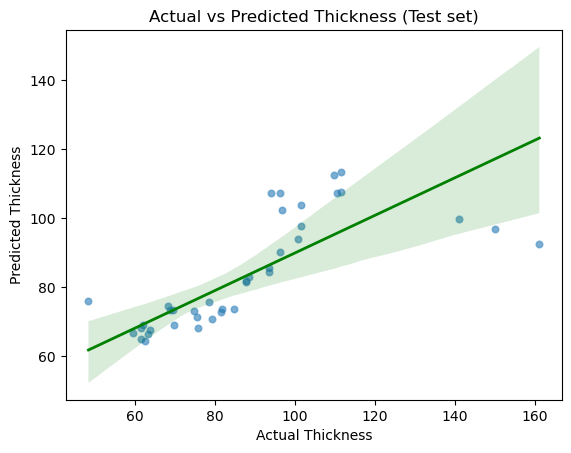

In [23]:
import statsmodels.api as sm
import seaborn as sns

# 그래프 그리기
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

In [24]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,71.460897
1,61.300000,65.089342
2,68.700000,73.470924
3,96.633333,102.458343
4,101.466667,97.738973
5,63.166667,66.368736
6,69.433333,73.413791
7,96.266667,90.101418
8,61.466667,68.206197
9,111.533333,113.274258


In [25]:
from sklearn.metrics import mean_squared_error
# 테스트 세트에서의 RMSE 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('MSE: {0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))

MSE: 292.980, RMSE: 17.117
